In [ ]:
import IPython
import json
import os
import sys
import seaborn as sns65
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.signal import savgol_filter
from scipy.signal import find_peaks 

sys.path.append("../../")
import didgelab.calc.fft
from didgelab.calc.sim.sim import *
from didgelab.calc.fft import *

geo = [[0, 32], [44.75184929758991, 30.89970197995438], [49.57729126575668, 31.168923768960347], [54.967873192075956, 31.329326966681364], [90.6108950523339, 32.38992761443541], [115.66723345069371, 31.56010686410169], [382.3585011135245, 33.335466478176244], [577.3073704027173, 34.29253197515777], [595.5401720221591, 43.49680571141982], [613.772973641601, 51.998191018424194], [632.0057752610428, 59.1092720860049], [637.4393615513678, 63.00837626866012], [650.2385768804846, 64.25264473887026], [668.4713784999265, 67.00827535480059], [686.7041801193683, 67.14827594514578], [704.9369817388101, 64.6562176541145], [723.1697833582521, 59.72934903909098], [741.4025849776939, 52.76346753534913], [759.6353865971357, 44.32160075620578], [762.0464531285053, 40.36197031418674], [777.8681882165776, 35.08897441011461], [850.6776076051298, 34.72681290369601], [881.6055202312654, 35.50092333516528], [997.7959501744169, 64.3388143456884], [1127.3358777804367, 70.77864209499438], [1183.600555228752, 74.66572458191796], [1259.3473388074553, 77.3413373632347], [1536.218593051003, 82.5235463235756], [1615.388941763838, 83.01764041772911], [1650.176863581173, 84.3593888504906], [1679.773777156785, 85.50092333516528], [1680.9010451815461, 76.66737047937056], [1692.7146051403229, 87.5536368201435], [1696.0882133064615, 88.08876880586146], [1697.583895109889, 88.32601840156258], [1712.2821558389335, 90.6575012126019]]
geo = Geo(geo)
geo

In [190]:
da_path = '../../../../didge-archive/'
archive = json.load(open(os.path.join(da_path, 'didge-archive.json')))
didge = archive[1]
didge

{'name': 'Arusha',
 'stl-files': ['stl-files/arusha.zip'],
 'blender-files': ['blender-files/arusha.blend.zip'],
 'audio-samples': {'hand-open': 'audio-samples/arusha-hand1.wav',
  'hand-closed': 'audio-samples/arusha-hand2.wav',
  'neutral-sound': 'audio-samples/arusha-neutral-sound.wav',
  'song': 'audio-samples/arusha-short-song.wav'},
 'geometry': 'geometries/arusha.json',
 'shape': 'saxodidge',
 'images': ['images/arusha.jpg'],
 'description': 'Arusha (key: D) was designed as a didgeridoo with many toots that are well tuned. It is also loud and easy to play. I built it in a bend, saxodidge like shape. Unfortunately the tuning is a bit off. It is half-way between D and D#. Still, it is the main instrument that I use.',
 'license': '[Creative Commons BY-NC-SA 4.0 License](https://creativecommons.org/licenses/by-nc-sa/4.0/deed.en)',
 'thingiverse': 'https://www.thingiverse.com/thing:7013610'}

In [248]:
import numpy as np
from scipy.io import wavfile
from typing import Dict

def averaged_fft_spectrum(
    wav_path : str,
    window_size=4096,
    overlap=0.75,
    max_freq=1000,
    hanning_window=True
):
    # ---- Read WAV ----
    fs, signal = wavfile.read(wav_path)

    # Convert to mono if needed
    if signal.ndim > 1:
        signal = signal.mean(axis=1)

    signal = signal.astype(np.float64)

    # ---- Windowing setup ----
    hop_size = int(window_size * (1 - overlap))
    window = np.hamming(window_size)

    n_windows = (len(signal) - window_size) // hop_size + 1

    # Accumulate power spectra
    power_accum = np.zeros(window_size // 2 + 1)

    for i in range(n_windows):
        start = i * hop_size
        segment = signal[start:start + window_size]

        if len(segment) < window_size:
            break

        # Apply window
        if hanning_window:
            segment *= window

        # FFT
        fft_vals = np.fft.rfft(segment)

        # Power spectrum
        power = np.abs(fft_vals) ** 2

        power_accum += power

    # ---- Average ----
    power_avg = power_accum / n_windows

    # Convert to magnitude spectrum
    magnitude = np.sqrt(power_avg)

    # Frequency axis
    freqs = np.fft.rfftfreq(window_size, d=1/fs)

    i = np.arange(len(freqs))[freqs<max_freq]
    freqs = freqs[i]
    magnitude = magnitude[i]

    info = {
        "signal_length_seconds": len(signal) / fs,
        "signal_length_samples": len(signal),
        "sample_rate": fs,
        "n_windows": n_windows,
        "window_size": window_size,
        "max_resolution_hz": fs / window_size
    }

    return freqs, magnitude, info

def compute_true_fft_and_peaks(didge : Dict):
    path = os.path.join(da_path, didge['audio-samples']['song'])
    #path = "samples/arusha.wav"
    true_freqs, magnitude, fft_info = averaged_fft_spectrum(path, window_size=1024*32, hanning_window=True)
    #magnitude = np.log2(magnitude)

    magnitude = magnitude/magnitude.max()
    i_peaks = find_peaks(magnitude, prominence=0.05)[0]
    true_peak_freqs = true_freqs[i_peaks]
    true_peak_magnitues = magnitude[i_peaks]

    return true_freqs, magnitude, true_peak_freqs, true_peak_magnitues

def compute_pred_impedance_and_peaks(didge : Dict):
    geo = json.load(open(os.path.join(da_path, didge['geometry'])))
    geo = Geo(geo)
    segments = create_segments(geo)
    pred_freqs = get_log_simulation_frequencies(1, 1000, 5)
    pred_impedances = compute_impedance(segments, pred_freqs)
    pred_impedances /= pred_impedances.max()

    i_peaks = find_peaks(pred_impedances)[0]
    peak_freqs = pred_freqs[i_peaks]
    peak_imp = pred_impedances[i_peaks]

    return pred_freqs, pred_impedances, peak_freqs, peak_imp

def match_peaks(x_from, y_from, x_to, y_to):
    df = []
    for f,i in zip(x_to, y_to):
        i = np.argmin(np.abs(f-x_from))
        df.append([f, i, x_from[i], y_from[i]])
    return pd.DataFrame(df, columns=['x_from', 'y_from', 'x_to', 'y_to'])
        
df = []
for didge in archive:
    pred_freqs, pred_impedances, pred_peak_freqs, pred_peak_imp = compute_pred_impedance_and_peaks(didge)
    true_freqs, magnitude, true_peak_freqs, true_peak_magnitues = compute_true_fft_and_peaks(didge)

    match = match_peaks(true_peak_freqs, true_peak_magnitues, pred_peak_freqs, pred_peak_imp)
    match['didge'] = didge['name']
    match['shape'] = didge['shape']
    match = match[0:3]
    df.append(match)

df = pd.concat(df)
df['diff'] = cent_diff(df.x_from, df.x_to)
df

,x_from,y_from,x_to,y_to,didge,shape,diff
0,92.091749,2,93.750000,1.000000,Malveira,straight,30.896142
1,183.652323,4,187.500000,0.406199,Malveira,straight,35.896142
2,350.717757,6,372.070312,0.120269,Malveira,straight,102.317767
0,73.516695,3,74.707031,1.000000,Arusha,saxodidge,27.806553
1,146.609353,7,150.878906,0.735135,Arusha,saxodidge,49.696775
2,219.665831,9,221.191406,0.329045,Arusha,saxodidge,11.981830
0,73.516695,2,74.707031,1.000000,Nazare,straight,27.806553
1,181.542896,4,166.992188,0.075139,Nazare,straight,-144.635841
2,279.169980,5,297.363281,0.088136,Nazare,straight,109.299243
0,73.304676,1,76.171875,1.000000,Kizimkazi,straight,66.423804


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Malveira'),
  Text(1, 0, 'Arusha'),
  Text(2, 0, 'Nazare'),
  Text(3, 0, 'Kizimkazi'),
  Text(4, 0, 'Open Didgeridoo'),
  Text(5, 0, 'Open Didgeridoo Straight'),
  Text(6, 0, 'Tamaki1'),
  Text(7, 0, 'Tamaki2'),
  Text(8, 0, 'Matema')])

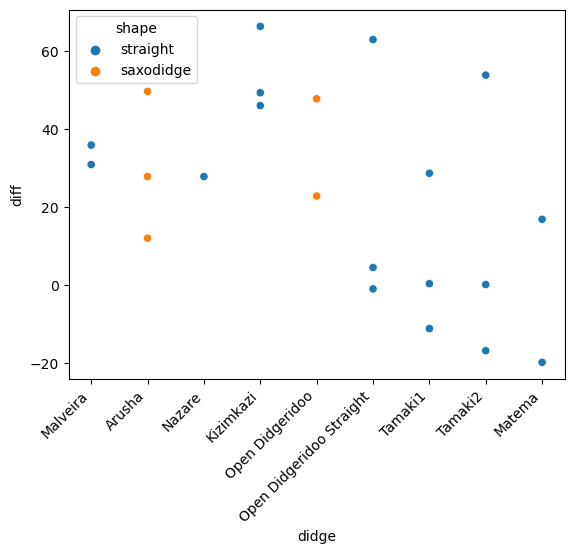

In [252]:
import seaborn as sns

sns.scatterplot(data=df.query('abs(diff) < 100'), x='didge', y='diff', hue='shape')
plt.xticks(rotation=45, ha='right')


In [ ]:
a = [1,2,3,4]
b = [3,4,5,6]



,note_name,cent_diff,note_nr,freq,impedance,rel_imp
0,D2,2.368344,-31,73.516695,21.411771,1.000000
1,D3,-2.631656,-19,146.609353,9.112844,0.425600
2,A3,-2.631656,-12,219.665831,11.835005,0.552734
3,F4,2.368344,-4,349.706306,0.437023,0.020410
4,A4,2.368344,0,440.602336,16.311108,0.761782
5,F5,-7.631656,8,695.384291,5.791502,0.270482
6,B5,2.368344,14,989.118801,1.656847,0.077380


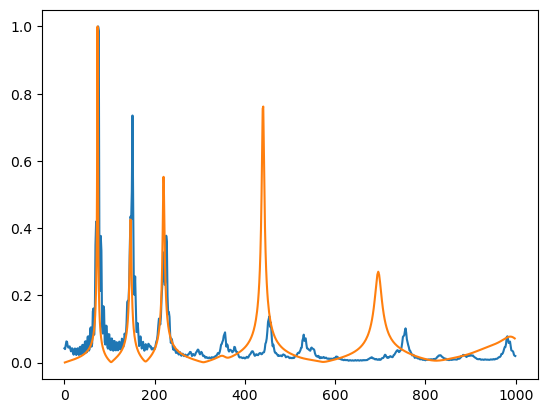

In [205]:
geo = json.load(open(os.path.join(da_path, didge['geometry'])))
geo = Geo(geo)
segments = create_segments(geo)
pred_freqs = get_log_simulation_frequencies(1, 1000, 5)
pred_impedances = compute_impedance(segments, pred_freqs)

plt.plot(true_freqs, magnitude)
plt.plot(pred_freqs, pred_impedances / pred_impedances.max())
pred_notes = get_notes(pred_freqs, pred_impedances)
pred_notes


In [216]:
true_freqs = []
for pred_f in pred_notes.freq:
    true_f = true_peak_freqs[np.argmin(np.abs(true_peak_freqs-pred_f))]
    true_freqs.append(true_f)

pred_notes['true_freq'] = true_freqs
pred_notes['diff'] = (pred_notes.true_freq - pred_notes.freq)

diffs = []
for f in pred_notes.true_freq:
    d = freq_to_note_and_cent(f)
    diffs.append(d[1])

pred_notes['true_cent_diff'] = diffs
pred_notes.round(2)

,note_name,cent_diff,note_nr,freq,impedance,rel_imp,true_freq,diff,true_cent_diff
0,D2,2.37,-31,73.52,21.41,1.00,74.71,1.19,30.17
1,D3,-2.63,-19,146.61,9.11,0.43,150.88,4.27,47.07
2,A3,-2.63,-12,219.67,11.84,0.55,221.19,1.53,9.35
3,F4,2.37,-4,349.71,0.44,0.02,355.96,6.25,33.04
4,A4,2.37,0,440.60,16.31,0.76,454.10,13.50,-45.39
5,F5,-7.63,8,695.38,5.79,0.27,755.86,60.48,36.74
6,B5,2.37,14,989.12,1.66,0.08,981.45,-7.67,-11.11


array([ 72.01736493,  72.19684746,  72.51094189,  73.04938948,
        73.40835454,  73.72244896,  73.94680213,  74.17115529,
        74.30576718,  74.53012035,  74.61986161,  74.84421477,
        75.06856794,  75.20317983,  75.33779173,  75.42753299,
        75.56214489,  75.74162742,  75.83136869,  75.96598058,
        76.05572185,  76.23520438,  76.36981627,  76.50442817,
        76.63904007,  76.77365196,  77.04287576,  77.17748766,
        77.44671145,  77.58132335, 143.72063544, 144.79753062,
       145.11162505, 145.33597821, 145.65007263, 145.96416706,
       146.32313212, 146.63722655, 146.86157971, 147.17567413,
       147.2654154 , 147.4000273 , 147.48976856, 147.71412172,
       147.80386299, 148.16282805, 148.25256931, 148.47692247,
       148.56666374, 148.7910169 , 149.10511133, 149.37433512,
       149.68842955, 150.00252397, 150.09226524, 150.22687713,
       150.40635966, 150.67558346, 150.76532472, 150.89993662,
       151.12428978, 151.25890168, 151.39351358, 151.57

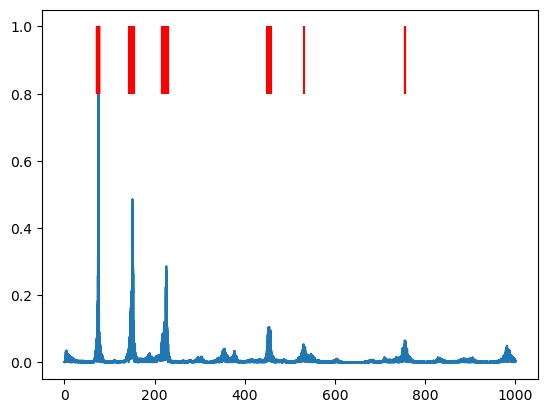

In [196]:
sampFreq, sound = wavfile.read(path)

# use only left channel if signal is stereo
if len(sound.shape)==2:
    signal = sound[:,0]
else:
    signal = sound

size=len(signal)

desired_length_seconds = 1
desired_length_samples = desired_length_seconds * sampFreq

if size < desired_length_samples:
    new_signal = np.zeros(desired_length_samples)
    new_signal[0:size] = signal
    signal = new_signal

fft_spectrum = np.fft.rfft(signal, n=size)
freq = np.fft.rfftfreq(size, d=1./sampFreq)
fft_spectrum_abs = np.abs(fft_spectrum)

i=0
maxfreq=1000
while i<len(freq) and freq[i]<=maxfreq:
    i+=1
freq = freq[0:i]
fft_spectrum_abs = fft_spectrum_abs[0:i]
fft_spectrum_abs /= fft_spectrum_abs.max()
i_peaks = find_peaks(fft_spectrum_abs, prominence=0.05)[0]
peak_f = freq[i_peaks]

plt.plot(freq, fft_spectrum_abs)
plt.vlines(peak_f, 0.8, 1, color='red')
peak_f

NameError: name 'size' is not defined

,note_name,cent_diff,note_nr,freq,impedance,rel_imp
0,D2,2.368344,-31,73.516695,21.411771,1.000000
1,D3,-2.631656,-19,146.609353,9.112844,0.425600
2,A3,-2.631656,-12,219.665831,11.835005,0.552734
3,F4,2.368344,-4,349.706306,0.437023,0.020410
4,A4,2.368344,0,440.602336,16.311108,0.761782
5,F5,-7.631656,8,695.384291,5.791502,0.270482
6,B5,2.368344,14,989.118801,1.656847,0.077380


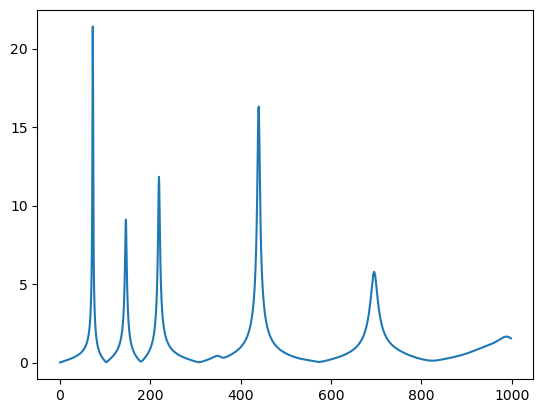

In [200]:
geo = json.load(open(os.path.join(da_path, didge['geometry'])))
geo = Geo(geo)
segments = create_segments(geo)
pred_freqs = get_log_simulation_frequencies(1, 1000, 5)
pred_impedances = compute_impedance(segments, pred_freqs)

plt.plot(pred_freqs, pred_impedances)
pred_notes = get_notes(pred_freqs, pred_impedances)
pred_notes


In [ ]:
pred_freqs, amps = do_fft(path)
i_peak = find_peaks(amps)[0]
print(pred_freqs[i_peak])

[  7.99927444  23.99782333  55.9949211   71.99346998 111.98984219
 143.98693996 167.98476329 191.98258661 207.9811355  231.97895882
 271.97533104 287.97387992 311.97170325 343.96880102 359.9673499
 383.96517323 423.96154544 439.96009432 455.95864321 479.95646653
 503.95428986 535.95138763 551.94993651 583.94703428 615.94413205
 647.94122982 663.9397787  679.93832759 703.93615092 727.93397424
 751.93179757 767.93034645 799.92744422 815.92599311 847.92309088
 879.92018865 919.91656086 935.91510974 959.91293307 991.91003084]
